In [9]:
#########################################################################################################################################
# 9 August 2020                                                                                                                         #
# Davide Valsecchi, Abraham Tishelman-Charny                                                                                            #
#                                                                                                                                       #
# The purpose of this python module is to optimize a second set of ECAL L1 weights for EB spike rejection.                              #
#                                                                                                                                       #
# ##-- Run Once: (SWAN): !pip install --user torch (lxplus:) pip install --user torch                                                   #
# ##-- Example location of pytorch installation: /afs/cern.ch/user/<userLetter>/<userName>/.local/lib/python3.6/site-packages/torch/    #
# ##-- Run on every lxplus instance: source /cvmfs/sft.cern.ch/lcg/views/LCG_98/x86_64-centos7-gcc10-opt/setup.sh                       #
                                                                                                                                        #       
#########################################################################################################################################

import torch
import ROOT as R 
import h5py
import numpy as np
import argparse 
import sys 
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import pickle

# mpl.rcParams['figure.figsize'] = (5,5)
# mpl.rcParams['figure.dpi'] = 150
# mpl.rcParams["image.origin"] = 'lower'
from sklearn.model_selection import train_test_split

Welcome to JupyROOT 6.24/06


In [10]:
##-- Choose Simulation Output to run on based on PU 
# PU = 0
PU = 50

In [157]:
##-- Copy h5 file(s) with simulation output(s)

!wget http://atishelm.web.cern.ch/atishelm/EcalL1Optimization/DoubleWeightsOptimization/h5Files/data_PU0.h5
!wget http://atishelm.web.cern.ch/atishelm/EcalL1Optimization/DoubleWeightsOptimization/h5Files/data_PU50.h5
!wget http://atishelm.web.cern.ch/atishelm/EcalL1Optimization/DoubleWeightsOptimization/h5Files/PU0_tryingtoAddPU.h5 ##-- PU digis added         
!wget http://atishelm.web.cern.ch/atishelm/EcalL1Optimization/DoubleWeightsOptimization/h5Files/PU50_tryingtoAddPU.h5 ##-- PU digis added         

--2020-10-21 20:36:11--  http://atishelm.web.cern.ch/atishelm/EcalL1Optimization/DoubleWeightsOptimization/h5Files/data_PU0.h5
Resolving atishelm.web.cern.ch (atishelm.web.cern.ch)... 188.185.67.197, 2001:1458:d00:1::100:3bf
Connecting to atishelm.web.cern.ch (atishelm.web.cern.ch)|188.185.67.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183930496 (175M) [text/plain]
Saving to: ‘data_PU0.h5.2’

100%[======================================>] 183,930,496 12.8MB/s   in 12s    

2020-10-21 20:36:24 (14.1 MB/s) - ‘data_PU0.h5.2’ saved [183930496/183930496]

--2020-10-21 20:36:30--  http://atishelm.web.cern.ch/atishelm/EcalL1Optimization/DoubleWeightsOptimization/h5Files/data_PU50.h5
Resolving atishelm.web.cern.ch (atishelm.web.cern.ch)... 188.185.67.197, 2001:1458:d00:1::100:3bf
Connecting to atishelm.web.cern.ch (atishelm.web.cern.ch)|188.185.67.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183930496 (175M) [text/plain]
Saving to

In [11]:
##-- Created output directory if it doesn't exist

inline_plots = 1 # (1): Show plots in notebook output. (0): Do not show plots in notebook, but instead save to website 

if(not inline_plots):
    ol = '/eos/user/a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU%s/'%(PU) ## typical eos path as mounted on lxplus 
    ol_swan = '/eos/home-a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU%s/'%(PU) ## name as mounted on SWAN to make sure mkdir works 

    outDirec = '%s'%(ol_swan)
    prevDirec = "%s/../"%(ol_swan)
    if(not os.path.exists(outDirec)):
        print("Making Directory: %s"%(outDirec))
        os.system('mkdir %s'%(outDirec))
        os.system('cp %s/index.php %s'%(prevDirec,outDirec)) ##-- assumes you have a proper php file in your base directory 
    else: 
        print("%s Already Exists"%(outDirec))

    ##-- Create directory for simulation sample plots if it doesn't already exist     
    outDirec = '%s/Sample/'%(ol_swan)
    prevDirec = "%s/../"%(ol_swan)
    if(not os.path.exists(outDirec)):
        print("Making Directory: %s"%(outDirec))
        os.system('mkdir %s'%(outDirec))
        os.system('cp %s/index.php %s'%(prevDirec,outDirec)) ##-- assumes you have a proper php file in your base directory 
    else: 
        print("%s Already Exists"%(outDirec))    

    SampleOutDirec = '%s/Sample/'%(ol_swan)    
    
print("DONE")

DONE


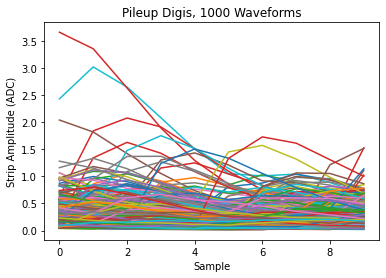

No handles with labels found to put in legend.


In [15]:
##-- Look at PU digis if h5 file has PU digis saved 

input_file = 'PU50_tryingtoAddPU.h5'
# input_file = 'data_PU50.h5'
device = torch.device("cpu")
dtype = torch.float

numWaveforms = 1000

h5f = h5py.File(input_file, 'r')

PUdigis = h5f['pileupDigis']

fig, ax = plt.subplots()
plt.plot(PUdigis[:numWaveforms,:].T)
ax.set_title("Pileup Digis, %s Waveforms"%(numWaveforms))
ax.set_xlabel("Sample")
ax.set_ylabel("Strip Amplitude (ADC)")
if(inline_plots):
    plt.show()
else:
    plt.savefig('%s/PileupDigis_%s-waveforms.png'%(SampleOutDirec,numWaveforms))
    plt.savefig('%s/PileupDigis_%s-waveforms.pdf'%(SampleOutDirec,numWaveforms))
plt.legend()
plt.close()

In [17]:
##-- Extract Values from h5 file 

input_file = 'data_PU%s.h5'%(PU)

##-- H5 File Variables:

# firstSetDigis
# secondSetDigis
# signalEnergy
# spikeEnergy
# spikeTime

device = torch.device("cpu")
dtype = torch.float

h5f = h5py.File(input_file, 'r')

digis1 = h5f['firstSetDigis']
digis2 = h5f['secondSetDigis']
signalEnergy = h5f['signalEnergy'][:]
spikeEnergy = h5f['spikeEnergy'][:]
spikeTime = h5f['spikeTime'][:]

In [18]:
numWaveforms = 1000
nAxRows, nAxCols = 2, 2

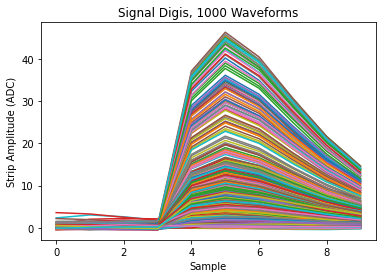

In [18]:
##-- Plot Signal Digis

fig, ax = plt.subplots()
plt.plot(digis1[:numWaveforms,:].T)
ax.set_title("Signal Digis, %s Waveforms"%(numWaveforms))
ax.set_xlabel("Sample")
ax.set_ylabel("Strip Amplitude (ADC)")
if(inline_plots):
    plt.show()
else:
    plt.savefig('%s/SigDigis_%s-waveforms.png'%(SampleOutDirec,numWaveforms))
    plt.savefig('%s/SigDigis_%s-waveforms.pdf'%(SampleOutDirec,numWaveforms))
plt.close()

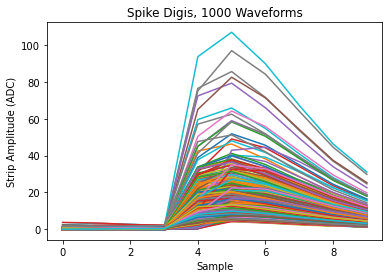

In [19]:
##-- Plot Spike Digis

fig, ax = plt.subplots()
plt.plot(digis2[:numWaveforms,:].T)
ax.set_title("Spike Digis, %s Waveforms"%(numWaveforms))
ax.set_xlabel("Sample")
ax.set_ylabel("Strip Amplitude (ADC)")
if(inline_plots):
    plt.show()
else:
    plt.savefig('%s/SpikeDigis_%s-waveforms.png'%(SampleOutDirec,numWaveforms))
    plt.savefig('%s/SpikeDigis_%s-waveforms.pdf'%(SampleOutDirec,numWaveforms))
plt.close()

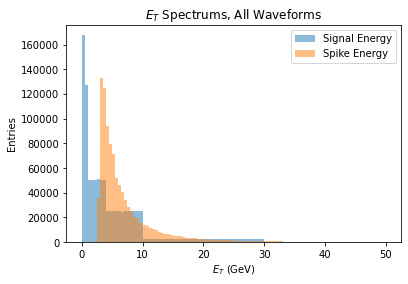

In [20]:
##-- Plot Signal Strip Energies

fig, ax = plt.subplots()
plt.hist(signalEnergy, bins=100, range=(0,50), alpha=0.5, label="Signal Energy")
plt.hist(spikeEnergy, bins=100, range=(0,50), alpha=0.5, label="Spike Energy")
plt.legend(loc='upper right')
ax.set_title(r'$E_{T}$ Spectrums, All Waveforms')
ax.set_xlabel(r'$E_{T}$ (GeV)')
ax.set_ylabel("Entries")
if(inline_plots):
    plt.show()
else:
    plt.savefig('%s/Energies_allWaveforms.png'%(SampleOutDirec))
    plt.savefig('%s/Energies_allWaveforms.pdf'%(SampleOutDirec))
plt.close()

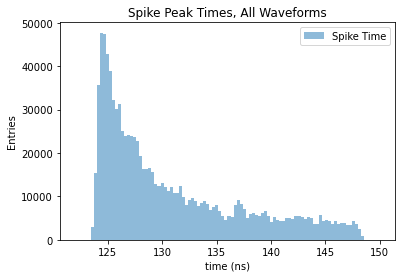

In [21]:
##-- Plot Spike Peak Times 

fig, ax = plt.subplots()
ax.set_title("Spike Peak Times, All Waveforms")
plt.hist(spikeTime, bins=100, range=(122,150), alpha=0.5, label="Spike Time")
plt.legend(loc='upper right')
ax.set_xlabel("time (ns)")
ax.set_ylabel("Entries")
if(inline_plots):
    plt.show()
else:
    plt.savefig('%s/SpikeTimes_allWaveforms.png'%(SampleOutDirec))
    plt.savefig('%s/SpikeTimes_allWaveforms.pdf'%(SampleOutDirec))
plt.close()

In [19]:
##-- Get digis for amp calc

Digis1_b = h5f["firstSetDigis"][:,2:7]
Digis2_b = h5f["secondSetDigis"][:,2:7] ##-- separate final weight to get sum = 0 

In [20]:
numWaveforms = 1000
nAxRows, nAxCols = 1, 2
width, height = 10, 3

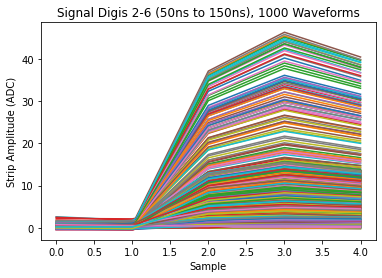

In [24]:
##-- Plot Signal Digis from 50ns to 150ns, used for reco A calculation

fig, ax = plt.subplots()
plt.plot(Digis1_b[:numWaveforms,:].T)
ax.set_title("Signal Digis 2-6 (50ns to 150ns), %s Waveforms"%(numWaveforms))
ax.set_xlabel("Sample")
ax.set_ylabel("Strip Amplitude (ADC)")
if(inline_plots):
    plt.show()
else:
    plt.savefig('%s/SigDigis_2-6_%s-waveforms.png'%(SampleOutDirec,numWaveforms))
    plt.savefig('%s/SigDigis_2-6_%s-waveforms.pdf'%(SampleOutDirec,numWaveforms))
plt.close()

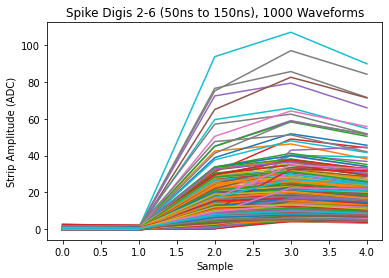

In [25]:
##-- Plot Spike Digis from 50ns to 150ns, used for reco A calculation

fig, ax = plt.subplots()
plt.plot(Digis2_b[:numWaveforms,:].T)
ax.set_title("Spike Digis 2-6 (50ns to 150ns), %s Waveforms"%(numWaveforms))
ax.set_xlabel("Sample")
ax.set_ylabel("Strip Amplitude (ADC)")
if(inline_plots):
    plt.show()
else:
    plt.savefig('%s/SpikeDigis_2-6.png'%(SampleOutDirec))
    plt.savefig('%s/SpikeDigis_2-6.pdf'%(SampleOutDirec))
plt.close()

In [21]:
##-- Create training and validation tensors with pyTorch

mask = signalEnergy[:] > 0.01 ##-- 10 MeV , try zero first maybe
signalEnergyVals =torch.tensor(signalEnergy[mask],dtype=dtype, device=device,requires_grad = False)
nSamples = Digis1_b[mask].shape[0]
val_fract = 0.1
nTrainSamples = int(nSamples*(1-val_fract))
nValSamples = nSamples - nTrainSamples

##-- Here is where you would choose to train on certain energies by setting the mask based on signal energy ^^^ above 
# may want to try optimizing on low energy signal, validating on low energy signal 

##-- Set Training Events 
Digis1_b_train = torch.tensor(Digis1_b[mask][:nTrainSamples],dtype=dtype,device=device,requires_grad=False)
Digis2_b_train = torch.tensor(Digis2_b[mask][:nTrainSamples],dtype=dtype,device=device,requires_grad=False)
signalEnergyVals_train = torch.tensor(signalEnergy[mask][:nTrainSamples],dtype=dtype,device=device,requires_grad=False)
spikeEnergyVals_train = torch.tensor(spikeEnergy[mask][:nTrainSamples],dtype=dtype,device=device,requires_grad=False)
spikeTimeVals_train = torch.tensor(spikeTime[mask][:nTrainSamples],dtype=dtype,device=device,requires_grad=False)

##-- Set Validation Events 
Digis1_b_val = torch.tensor(Digis1_b[mask][nTrainSamples:],dtype=dtype,device=device,requires_grad=False)
Digis2_b_val = torch.tensor(Digis2_b[mask][nTrainSamples:],dtype=dtype,device=device,requires_grad=False)
signalEnergyVals_val = torch.tensor(signalEnergy[mask][nTrainSamples:],dtype=dtype,device=device,requires_grad=False)
spikeEnergyVals_val = torch.tensor(spikeEnergy[mask][nTrainSamples:],dtype=dtype,device=device,requires_grad=False)
spikeTimeVals_val = torch.tensor(spikeTime[mask][nTrainSamples:],dtype=dtype,device=device,requires_grad=False)

##-- Define Training and validation data 
train_data = [Digis1_b_train,Digis2_b_train,signalEnergyVals_train,spikeEnergyVals_train,spikeTimeVals_train]
val_data = [Digis1_b_val,Digis2_b_val,signalEnergyVals_val,spikeEnergyVals_val,spikeTimeVals_val]

In [3]:
test = "abcdef"
test[4:]

'ef'

In [27]:
#-- want energy spectrum reweighting 
# plots in bins of energy and time

# prepare shuffled batches
##-- randomly batch samples 
def batch(xs,batch_size=1024):
    x = xs[0]
    import random
    a = list(range(x.shape[0]//batch_size))
    indexes = random.sample(a, k=len(a))
    #print(indexes)
    for i in indexes:
        yield [ xi[i*batch_size:(i+1)*batch_size] for xi in xs]

from collections import defaultdict
import json

##-- class for logic and saving information

class Experiment:
    
    def __init__(self, epochs,  batch_size, lr, lambda_sig, lambda_spike, lambda_norm,
                     min_delta=0.1, initial_weights=[-0.4504,  0.2303,  0.6132,  0.2275] , 
                     weights_1=[-0.546875, -0.546875,0.265625,0.484375,0.34375],verbose=True): ##--slightly different from emulator weights. Maybe these are PU opt. weights.
        
        ##-- initial_weights: for candidate 2nd set 
        ##-- weights_1: First set of weights 
        
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.lambda_sig = lambda_sig
        self.lambda_spike = lambda_spike
        self.lambda_norm = lambda_norm
        #min_delta value for recoA comparison
        self.min_delta = min_delta
        
        self.weights_1 = torch.tensor( weights_1, dtype=dtype, device=device, requires_grad=False)
        self.weights_2_four = torch.tensor(initial_weights, dtype=dtype, device=device, requires_grad=True) 
        
        self.history = defaultdict(list)
        self.is_lr_scheduled = False
        
        self.verbose = verbose
    
    
    def get_weights_2(self):
        return torch.cat((torch.unsqueeze(- sum(self.weights_2_four), -1), self.weights_2_four), 0) ##-- first weight = -sum of others 
        
    def evaluate(self, data, weights_2):
        digis1_b, digis2_b = data[0], data[1] 
#         digis1_b, digis2_b = data
#         digis1_b, digis2_b, signalEnergyVals, spikeEnergyVals, spikeTimeVals = data
#         digis1_b, digis2_b, signalEnergyVals, spikeEnergyVals, spikeTimeVals = data

        # zero out negative amplitude values
        A_w1_d1 = torch.clamp(digis1_b.matmul(self.weights_1), min=0.)
        A_w1_d2 = torch.clamp(digis2_b.matmul(self.weights_1), min=0.)
        A_w2_d1 = torch.clamp(digis1_b.matmul(weights_2), min=0.)
        A_w2_d2 = torch.clamp(digis2_b.matmul(weights_2), min=0.)

        return A_w1_d1,A_w1_d2,A_w2_d1,A_w2_d2
        
    def set_lr_scheduler(self,lr_sched):
        self.is_lr_scheduled = True
        self.lr_scheduler = lr_sched
    
    def train(self,train_data, val_data):
        # previous epoch weights for comparison
        prev_weights_2 = self.get_weights_2()
        
        for iepoch in range(self.epochs):
            #batch processing
            losses_epoch = []
            losses_sig = []
            losses_spike = []
            grad_strengths = [] 

            for data in batch(train_data, self.batch_size):
                # get current weights2
                current_weights_2 = self.get_weights_2()
                
                A_w1_d1,A_w1_d2,A_w2_d1,A_w2_d2 = self.evaluate(data, current_weights_2)
                
                # weights normalization
                W2_loss_limit = torch.sum(torch.abs(current_weights_2).clamp(min=1.) -1 ) * 100
                W2_loss_norm = torch.abs(current_weights_2).mean()
                
                loss_sig_eff = ((A_w2_d1 - A_w1_d1).clamp(min=-self.min_delta) + self.min_delta).mean()
                loss_spike_rej =  ((A_w1_d2 - A_w2_d2).clamp(min=-self.min_delta) + self.min_delta).mean()
                
                loss = self.lambda_sig* loss_sig_eff + self.lambda_spike * loss_spike_rej + self.lambda_norm* W2_loss_norm + W2_loss_limit
                
                # back propagation
                loss.backward()

                with torch.no_grad():                    
                    #stats for the epoch
                    losses_epoch.append(loss.item())
                    losses_sig.append(loss_sig_eff.item())
                    losses_spike.append(loss_spike_rej.item())
                    grad_strength = self.weights_2_four.grad.pow(2).sum().sqrt()
                    grad_strengths.append(grad_strength)
                    #print("{}) GRAD:".format(i), weights_2_five.grad, ' strength: ', grad_strength)
                
                    # gradient descent
                    self.weights_2_four -=  self.lr* self.weights_2_four.grad
                    self.weights_2_four.grad.zero_()
                    

            # Calculate signal efficiency and spike efficiency
            with torch.no_grad():      
                loss_epoch = np.mean(losses_epoch)
                loss_epoch_sig = np.mean(losses_sig)
                loss_epoch_spike = np.mean(losses_spike)
                grad_str = np.mean(grad_strengths)
                self.history['loss'].append(np.mean(loss_epoch))
                self.history['loss_sig'].append(np.mean(loss_epoch_sig))
                self.history['loss_spike'].append(np.mean(loss_epoch_spike))
                self.history['grad_mod'].append(grad_str)

                #evaluate on validation data
                current_weights_2 = self.get_weights_2()
                delta_w = current_weights_2 - prev_weights_2
                l_delta_w = delta_w.pow(2).sum().pow(0.5)
                prev_weights_2 = current_weights_2
                
                A_w1_d1_val,A_w1_d2_val,A_w2_d1_val,A_w2_d2_val = self.evaluate(val_data, current_weights_2)
                sig_eff_val = (A_w1_d1_val > A_w2_d1_val).sum() / float(nValSamples)
                spike_rej_val = (A_w1_d2_val < A_w2_d2_val).sum() / float(nValSamples)
                loss_sig_eff_val = ((A_w2_d1_val - A_w1_d1_val).clamp(min=-self.min_delta) + self.min_delta).mean()
                loss_spike_rej_val =  ((A_w1_d2_val - A_w2_d2_val).clamp(min=-self.min_delta) + self.min_delta).mean()
                self.history['sig_eff_val'].append(sig_eff_val.item())
                self.history['spike_rej_val'].append(spike_rej_val.item())
                self.history['loss_sig_val'].append(loss_sig_eff_val.item())
                self.history['loss_spike_val'].append(loss_spike_rej_val.item())
                
                self.history['A_w1_d1_val'].append(A_w1_d1_val)
                self.history['A_w2_d1_val'].append(A_w2_d1_val)
                self.history['A_w1_d2_val'].append(A_w1_d2_val)
                self.history['A_w2_d2_val'].append(A_w2_d2_val)
                
                self.history['sig_rej_matrix'].append(A_w2_d1_val > A_w1_d1_val)
                self.history['spike_rej_matrix'].append(A_w2_d2_val > A_w1_d2_val) ## -- is it possible to optimize on the map of > and < hits? Non-gradient I think...
    
                if self.verbose: print(f"{iepoch}) loss: {loss_epoch:.5f}, loss sig: {loss_epoch_sig:.5f}, loss spike: {loss_epoch_spike:.5f}, |grad|: {grad_str:.2f}, Sig.eff.{sig_eff_val*100:.2f}, Spike rej.{spike_rej_val*100:.2f}")

                self.history['weights_2'].append(current_weights_2.detach().numpy())
                if self.verbose: print("weights_2:",self.history['weights_2'][-1])
                self.history['delta_weights'].append(delta_w.detach().numpy())
                self.history['delta_weights_mod'].append(l_delta_w.item())
                
                # Update learning rate
                ##-- should vary during training
                if self.is_lr_scheduled:
                    self.lr = self.lr_scheduler(self.lr, iepoch, metadata={'grad_strenght': grad_str})
            
            
    def save(self, outputfile):
        json.dump(str(self.__dict__), open(outputfile, 'w'))
        
def get_lr_scheduler_exp(decay_const=0.95, delay=1, verbose=False):
    def lr_decay_exp(lr,epoch, metadata):
        new_lr = lr * (decay_const **(float(epoch)/delay))
        if verbose: print(f"Updating lr: epoch {epoch}, from {lr:.8f} to {new_lr:.8f}")
        return new_lr
    return lr_decay_exp        

In [5]:
nEpochs = 40

# lambda_sigs
xminval, xmaxval, xInterval = 0, 2, 0.5
# xminval, xmaxval, xInterval = 0, 0.25, 0.025

# lambda_spikes
yminval, ymaxval, yInterval = 0, 2, 0.5
# yminval, ymaxval, yInterval = 0, 0.25, 0.025

precision = 1000. ## for properly getting integer interval values from range function 

lambda_sigs = [i/precision for i in range(int(precision*xminval),int(precision*(xmaxval+xInterval)),int(precision*xInterval))]
lambda_spikes = [i/precision for i in range(int(precision*yminval),int(precision*(ymaxval+yInterval)),int(precision*yInterval))]

In [6]:
##-- Perform Training, Systematically Scanning Training Parameters

# nEpochs = 40
nEpochs = 5
batch_size_ = 256 
learningRate = 5e-3
lambda_norm_val = 0.1
min_delta_val = 0.5 
initial_weights_vals = [-0.484375,-0.125,0.53125,0.5625] ## +15ns weights for signal efficiency ~ 99% (with PU 50 and Peak Finder) 
verbose = 0
maxLambdaDiff = 100.

# lambda_sigs
xminval, xmaxval, xInterval = 0, 2, 0.5
# xminval, xmaxval, xInterval = 0, 0.25, 0.025

# lambda_spikes
yminval, ymaxval, yInterval = 0, 2, 0.5
# yminval, ymaxval, yInterval = 0, 0.25, 0.025

precision = 1000. ## for properly getting integer interval values from range function 

lambda_sigs = [i/precision for i in range(int(precision*xminval),int(precision*(xmaxval+xInterval)),int(precision*xInterval))]
lambda_spikes = [i/precision for i in range(int(precision*yminval),int(precision*(ymaxval+yInterval)),int(precision*yInterval))]

print("lambda_sigs:",lambda_sigs)
print("lambda_spikes:",lambda_spikes)
        
print("DONE")

lambda_sigs: [0.0, 0.5, 1.0, 1.5, 2.0]
lambda_spikes: [0.0, 0.5, 1.0, 1.5, 2.0]
DONE


In [ ]:
# Run training 
LambdaSigVals = []
LambdaSpikeVals = []
Histories = [] 

for lambda_sig_val in lambda_sigs:
    for lambda_spike_val in lambda_spikes:
        if(abs(lambda_sig_val - lambda_spike_val) > maxLambdaDiff): continue ##-- To scan only on the diagonal 
        print("Optimizing on (lambda_sig, lambda_spike) = (",lambda_sig_val,",",lambda_spike_val,") ...")
        optimization = Experiment(nEpochs, batch_size_, learningRate, lambda_sig=lambda_sig_val, lambda_spike=lambda_spike_val, 
                                  lambda_norm=lambda_norm_val, min_delta=min_delta_val, initial_weights=initial_weights_vals, verbose=verbose)
        optimization.set_lr_scheduler(get_lr_scheduler_exp(0.8, 6, verbose))
        optimization.train( train_data, val_data)
        lambda_sig_val_str = str(lambda_sig_val)
        lambda_sig_val_str = lambda_sig_val_str.replace('.','p')
        lambda_spike_val_str = str(lambda_spike_val)
        lambda_spike_val_str = lambda_spike_val_str.replace('.','p')   
        
        thisHist = optimization.history 
        Histories.append(thisHist)
        LambdaSigVals.append(lambda_sig_val)
        LambdaSpikeVals.append(lambda_spike_val)
#         print("FINISHED Optimizing on (lamb_sig, lamb_spike) = (",lambda_sig_val,",",lambda_spike_val,")...")

In [30]:
##-- Pickle the training outputs so you don't need to repeat the training!!

HistoriesName = "Histories_PU%s_%sepoch_lamb0-2.p"%(PU,nEpochs)

pickle.dump( Histories, open( HistoriesName, "wb" ))
pickle.dump( LambdaSigVals, open( "LambdaSigVals.p", "wb" ))
pickle.dump( LambdaSpikeVals, open( "LambdaSpikeVals.p", "wb" ))

In [13]:
##-- Load previously pickled trainings

HistoriesName = "Histories_PU%s_%sepoch_lamb0-2.p"%(PU,nEpochs)

Histories = pickle.load( open( HistoriesName, "rb" ) )
LambdaSigVals = pickle.load( open( "LambdaSigVals.p", "rb" ) )
LambdaSpikeVals = pickle.load( open( "LambdaSpikeVals.p", "rb" ) )

In [32]:
##-- For each lambda pair, make a directory for output plots if it doesn't already exist 

if(inline_plots):
    plt.show()
else:

    for lambCombo_i in range(0,len(LambdaSigVals)):
        lSigVal = str(LambdaSigVals[lambCombo_i])
        lSpikeVal = str(LambdaSpikeVals[lambCombo_i])    
        outDirec = '%s/lSiglSpike_%s_%s'%(ol_swan,lSigVal,lSpikeVal)
        if(not os.path.exists(outDirec)):
            print("Making Directory: %s"%(outDirec))
            os.system('mkdir %s'%(outDirec))
            os.system('cp %s/index.php %s'%(ol_swan,outDirec)) ##-- assumes you have a proper php file in your base directory 
        else: 
            print("%s Already Exists"%(outDirec))

    ##-- And for plots that include all pairs 
    outDirec = '%s/COMBINED'%(ol_swan)
    if(not os.path.exists(outDirec)):
        print("Making Directory: %s"%(outDirec))
        os.system('mkdir %s'%(outDirec))
        os.system('cp %s/index.php %s'%(ol_swan,outDirec)) ##-- assumes you have a proper php file in your base directory 
    else: 
        print("%s Already Exists"%(outDirec))
        
print("DONE")

DONE


on lambda combo: 0 / 25


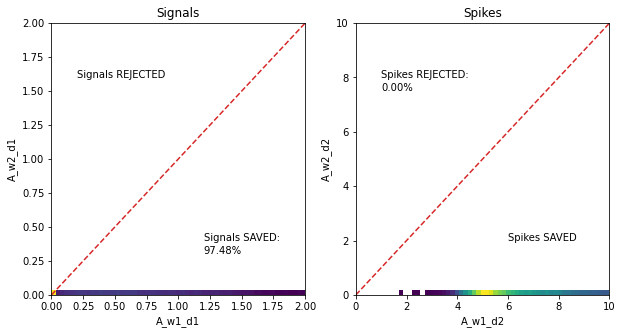

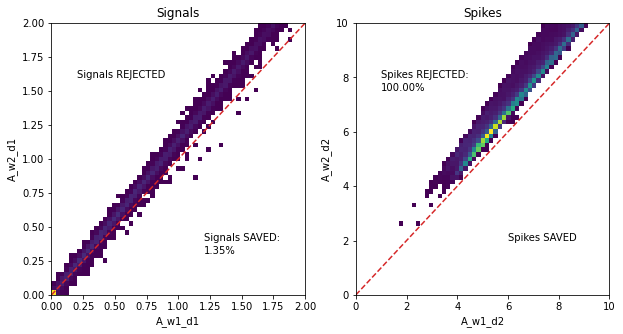

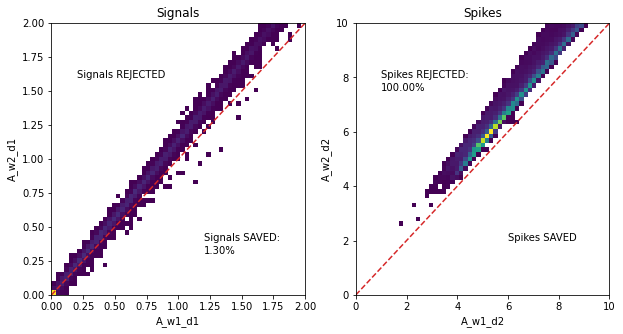

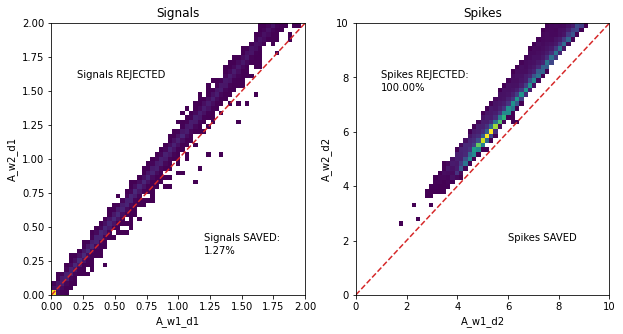

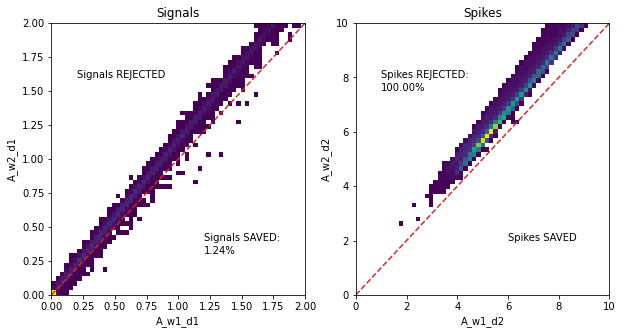

on lambda combo: 5 / 25


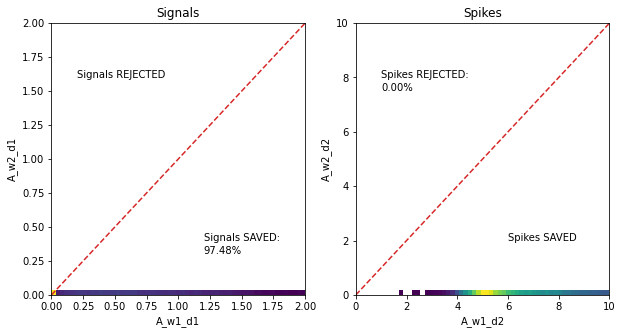

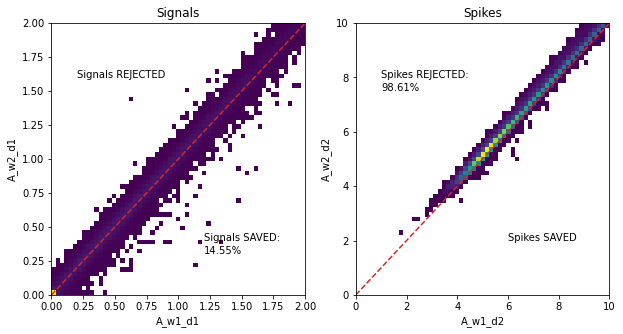

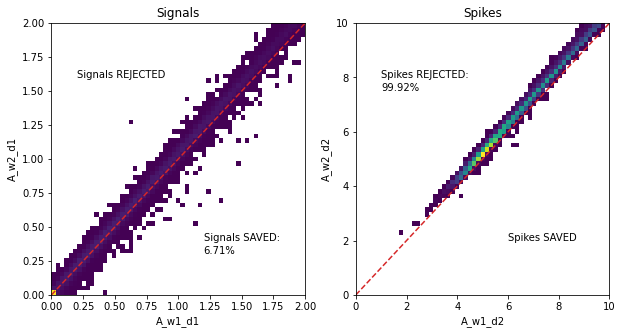

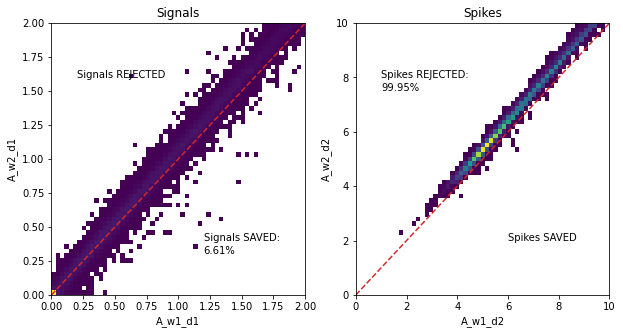

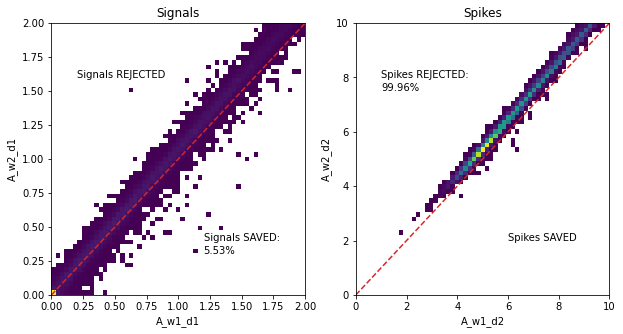

on lambda combo: 10 / 25


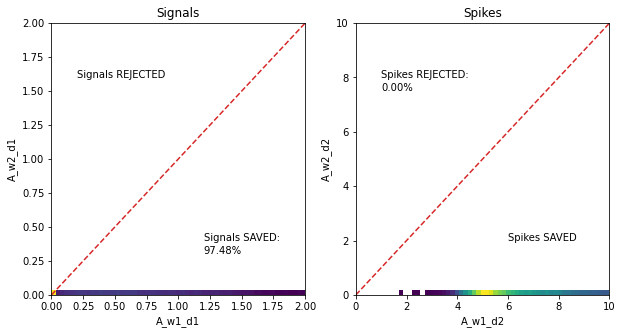

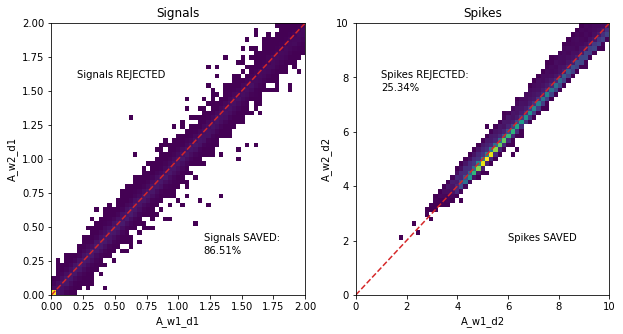

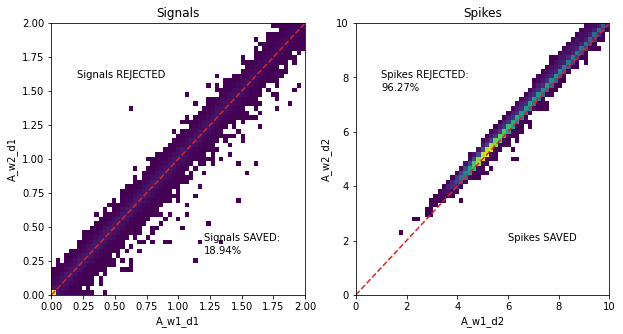

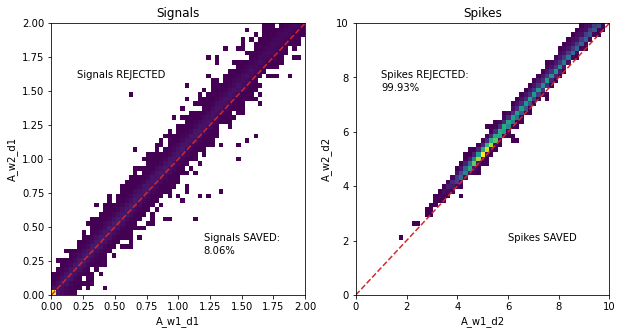

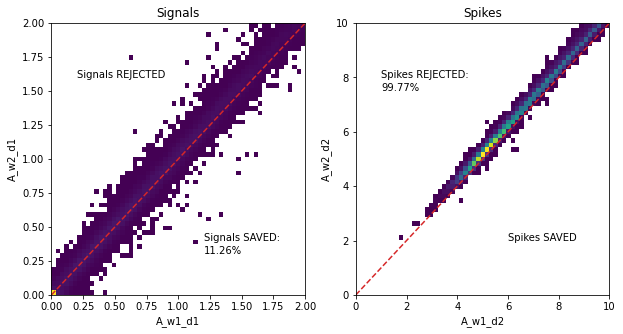

on lambda combo: 15 / 25


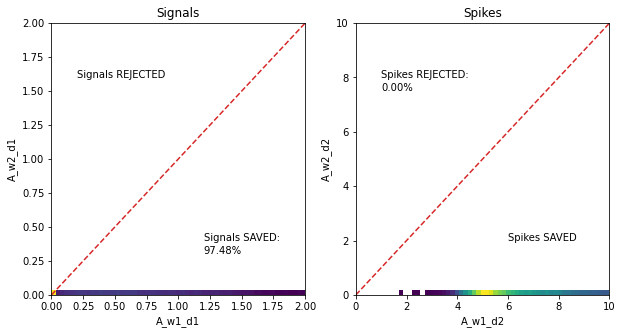

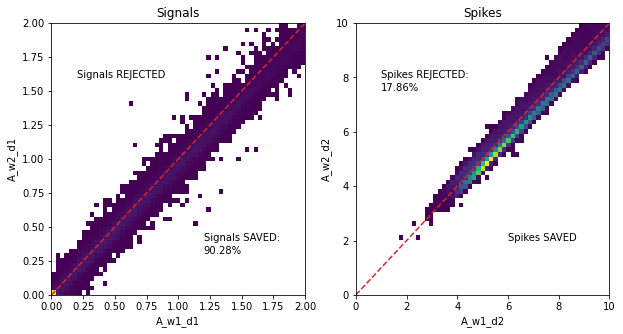

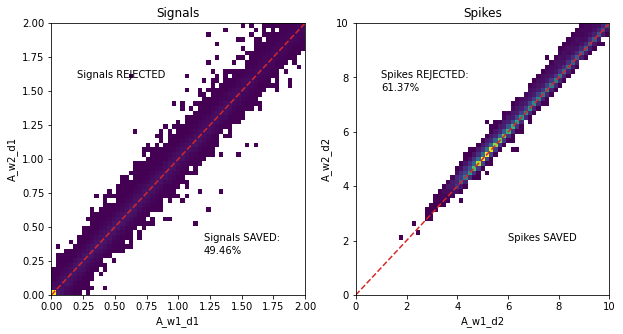

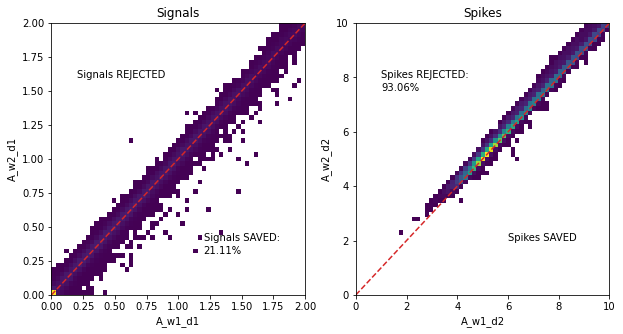

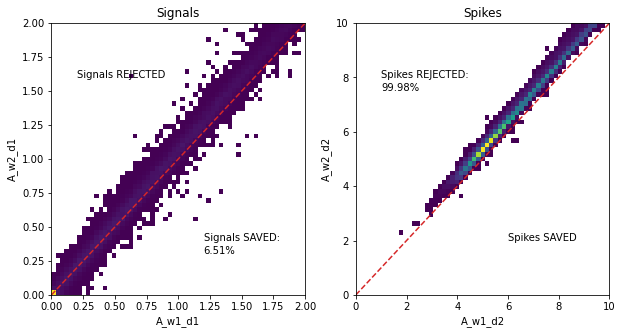

on lambda combo: 20 / 25


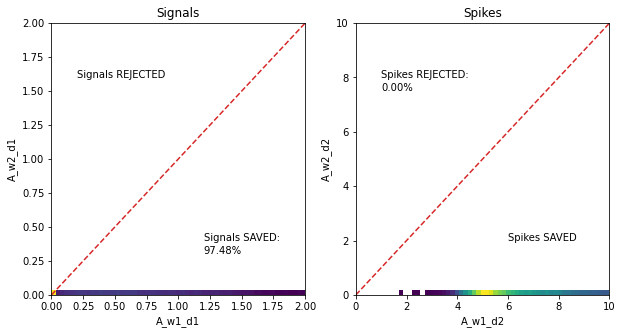

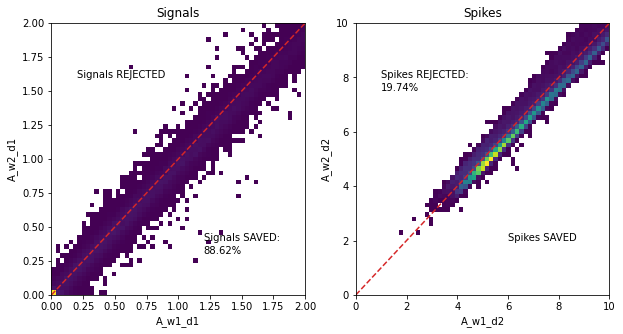

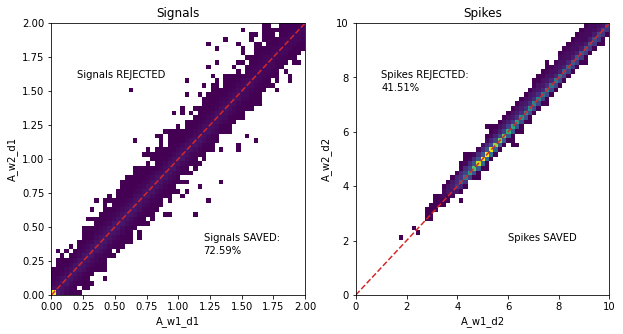

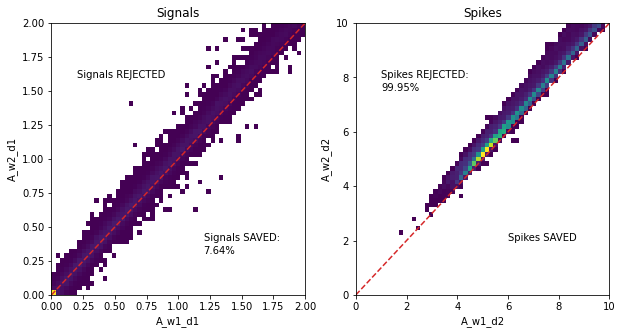

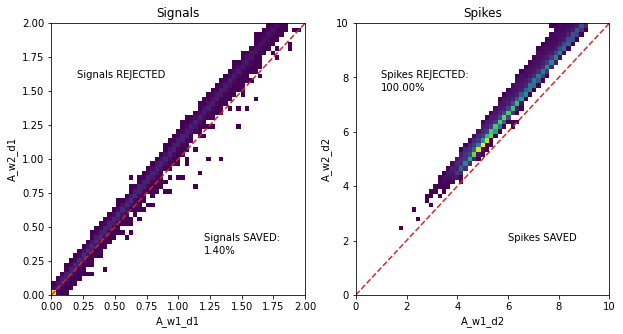

DONE


In [33]:
epochnumber = -1

N_lambCombos = len(LambdaSigVals)
for lambCombo_i in range(0,N_lambCombos):
    if(lambCombo_i%5==0): print("on lambda combo: %s / %s"%(lambCombo_i,N_lambCombos))
    lSigVal = str(LambdaSigVals[lambCombo_i])
    lSpikeVal = str(LambdaSpikeVals[lambCombo_i])
    outDirec = '%s/lSiglSpike_%s_%s'%(ol_swan,lSigVal,lSpikeVal)
 
    A_w1_d1_vals = Histories[lambCombo_i]['A_w1_d1_val'][epochnumber]
    A_w2_d1_vals = Histories[lambCombo_i]['A_w2_d1_val'][epochnumber]
    A_w1_d2_vals = Histories[lambCombo_i]['A_w1_d2_val'][epochnumber]
    A_w2_d2_vals = Histories[lambCombo_i]['A_w2_d2_val'][epochnumber]

    sig_eff_val = Histories[lambCombo_i]['sig_eff_val'][-1]
    spike_rej_val = Histories[lambCombo_i]['spike_rej_val'][-1]

    fig, ax = plt.subplots(1,2,figsize=(10,5))
    
    sigMin, sigMax = 0, 2
    spikeMin, spikeMax = 0, 10
    nBins = 60
    
    sigBins = np.linspace(sigMin,sigMax,nBins)
    spikeBins = np.linspace(spikeMin,spikeMax,nBins)
    
    ax[0].hist2d(np.array(A_w1_d1_vals),
                 np.array(A_w2_d1_vals),
                 bins=[sigBins,sigBins],
                 cmin=0.0000000001
                )
    ax[0].set_title("Signals")
    ax[0].set_xlabel("A_w1_d1")
    ax[0].set_ylabel("A_w2_d1")

    ax[0].plot([sigMin, sigMax], [sigMin, sigMax], ls="--", c="C3")
    
    ax[0].text(0.1*sigMax,0.8*sigMax,"Signals REJECTED")
    ax[0].text(0.6*sigMax,0.2*sigMax,"Signals SAVED:")
    ax[0].text(0.6*sigMax,0.15*sigMax,r'{0:.2f}%'.format(sig_eff_val*100))     #str(sig_eff_val))
    
    ax[1].hist2d(np.array(A_w1_d2_vals),
                 np.array(A_w2_d2_vals),
                 bins=[spikeBins,spikeBins],
                 cmin=0.0000000001
                )    
    
    ax[1].set_title("Spikes")
    ax[1].set_xlabel("A_w1_d2")
    ax[1].set_ylabel("A_w2_d2")
#     ax[1].plot([spikeMin, spikeMax], [spikeMin, spikeMax], ls="--", c=".3")
    ax[1].plot([spikeMin, spikeMax], [spikeMin, spikeMax], ls="--", c="C3")
    ax[1].text(0.1*spikeMax,0.8*spikeMax,"Spikes REJECTED:")
    ax[1].text(0.6*spikeMax,0.2*spikeMax,"Spikes SAVED") ## should we train the optimization on label position? 
    ax[1].text(0.1*spikeMax,0.75*spikeMax,r'{0:.2f}%'.format(spike_rej_val*100))
    if(inline_plots):
        plt.show()
    else:
        plt.savefig('%s/SigSpike2dMap_lSiglSpike_%s_%s.png'%(outDirec,lSigVal,lSpikeVal))
        plt.savefig('%s/SigSpike2dMap_lSiglSpike_%s_%s.pdf'%(outDirec,lSigVal,lSpikeVal))
    plt.close()
print("DONE")

In [ ]:
##-- Reco A values 

epochnumber = -1
N_lambCombos = len(LambdaSigVals)

for lambCombo_i in range(0,N_lambCombos):
    if(lambCombo_i%5==0): print("on lambda combo: %s / %s"%(lambCombo_i,N_lambCombos))
    lSigVal = str(LambdaSigVals[lambCombo_i])
    lSpikeVal = str(LambdaSpikeVals[lambCombo_i])
    outDirec = '%s/lSiglSpike_%s_%s'%(ol_swan,lSigVal,lSpikeVal)    
    
    A_w1_d1_vals = Histories[lambCombo_i]['A_w1_d1_val'][epochnumber]
    A_w2_d1_vals = Histories[lambCombo_i]['A_w2_d1_val'][epochnumber]
    A_w1_d2_vals = Histories[lambCombo_i]['A_w1_d2_val'][epochnumber]
    A_w2_d2_vals = Histories[lambCombo_i]['A_w2_d2_val'][epochnumber]
    
    fig, ax = plt.subplots()
    bins = np.linspace(-5,80,85)
    bins_str = "["
    for ib,b in enumerate(bins):
        bins_str += str(b)
        if(ib < len(bins)): bins_str += ","
    bins_str += "]"
    for wSet in [1,2]:
        for dSet in [1,2]:
            amp_str = "w%s_d%s"%(wSet,dSet)
            cmd = "plt.hist(A_%s_vals, alpha = 0.5, label = '%s', bins = %s)"%(amp_str,amp_str,bins_str)
            exec(cmd)
    plt.legend(loc='best')
    if(inline_plots):
        plt.show()
    else:    
        plt.savefig('%s/RecoAs_sigLspikeL-%s_%s.png'%(outDirec,lSigVal,lSpikeVal))
        plt.savefig('%s/RecoAs_sigLspikeL-%s_%s.pdf'%(outDirec,lSigVal,lSpikeVal))
    plt.close()

print("DONE")

on lambda combo: 0 / 25


In [ ]:
##-- Bin by bin signal eff and spike rej

epochNum = -1 ##-- Last Epoch 

sigEmin, sigEmax, sigEbins = 0, 5, 30 
spikeEmin, spikeEmax, spikeEbins = 2, 30, 30
spikeTimemin, spikeTimemax, spikeTimebins = 123, 150, 30 

sigEffvsEnergy_arrays, spikeEffvsEnergy_arrays, spikeEffvsTime_arrays = [], [], []
sigEnergyBins_centered_cpy, spikeEnergyBins_centered_cpy, spikeTimeBins_centered_cpy = [], [], []

N_lambCombos = len(LambdaSigVals)

for lambCombo_i in range(0,N_lambCombos):
    if(lambCombo_i%5==0): print("on lambda combo: %s / %s"%(lambCombo_i,N_lambCombos))
    lSigVal = str(LambdaSigVals[lambCombo_i])
    lSpikeVal = str(LambdaSpikeVals[lambCombo_i])  

    sig_eff_val = Histories[lambCombo_i]['sig_eff_val'][-1] ## -1 : final epoch  
    spike_rej_val = Histories[lambCombo_i]['spike_rej_val'][-1]
    
    sig_rej_matrix = Histories[lambCombo_i]['sig_rej_matrix'][epochNum].numpy() # last epoch
    spike_rej_matrix = Histories[lambCombo_i]['spike_rej_matrix'][epochNum].numpy() # last epoch 

    signalEnergyVals_ = val_data[2]
    spikeEnergyVals_ = val_data[3]
    spikeTimeVals_ = val_data[4]
    
    rejSigEnergies = signalEnergyVals_[sig_rej_matrix]
    rejSpikeEnergies = spikeEnergyVals_[spike_rej_matrix]
    rejSpikeTimes = spikeTimeVals_[spike_rej_matrix]
    
    ## -- Define bins 
    sigEnergyBins = np.linspace(sigEmin,sigEmax,int(sigEbins))
    spikeEnergyBins = np.linspace(spikeEmin,spikeEmax,int(spikeEbins))
    spikeTimeBins = np.linspace(spikeTimemin,spikeTimemax,int(spikeTimebins))    
    
    ## -- Get Rejection and Total bin Heights 
    rejSigEnergyBinVals, bins, patches = plt.hist(rejSigEnergies, bins = sigEnergyBins)
    allSigEnergyBinVals, bins, patches = plt.hist(signalEnergyVals_, bins = sigEnergyBins)
    
    rejSpikeEnergyBinvals, bins, patches = plt.hist(rejSpikeEnergies, bins = spikeEnergyBins)
    allSpikeEnergyBinvals, bins, patches = plt.hist(spikeEnergyVals_, bins = spikeEnergyBins)   
    
    rejSpikeTimeBinvals, bins, patches = plt.hist(rejSpikeTimes, bins = spikeTimeBins)
    allSpikeTimeBinvals, bins, patches = plt.hist(spikeTimeVals_, bins = spikeTimeBins)       
    
    ## -- Compute Efficiencies 
    acceptedSigEnergyBinVals = [] 
    for i,val in enumerate(rejSigEnergyBinVals):
        if(allSigEnergyBinVals[i] == 0): acceptedSpikeEnergyBinVals.append(0)
        else: acceptedSigEnergyBinVals.append(1 - rejSigEnergyBinVals[i]/allSigEnergyBinVals[i])
        
    acceptedSpikeEnergyBinVals = [] 
    for i,val in enumerate(rejSpikeEnergyBinvals):
        if(allSpikeEnergyBinvals[i] == 0): acceptedSpikeEnergyBinVals.append(0)
        else: acceptedSpikeEnergyBinVals.append(1 - rejSpikeEnergyBinvals[i]/allSpikeEnergyBinvals[i]) 
            
    acceptedSpikeTimeBinVals = [] 
    for i,val in enumerate(rejSpikeTimeBinvals):
        if(allSpikeTimeBinvals[i] == 0): acceptedSpikeTimeBinVals.append(0)
        else: acceptedSpikeTimeBinVals.append(1 - rejSpikeTimeBinvals[i]/allSpikeTimeBinvals[i])             
                
    ##-- Get Centered Bins
    sigEnergyBins_precision = (sigEmax - sigEmin) / float(sigEbins) 
    sigEnergyBins_centered = sigEnergyBins[:] 
    for i, val in enumerate(sigEnergyBins_centered):
        sigEnergyBins_centered[i] += sigEnergyBins_precision / 2
    sigEnergyBins_centered = sigEnergyBins_centered[:-1]
    
    sigEnergyBins_centered_cpy = sigEnergyBins_centered[:]
    
    spikeEnergyBins_precision = (spikeEmax - spikeEmin) / float(spikeEbins)
    spikeEnergyBins_centered = spikeEnergyBins[:]
    for i, val in enumerate(spikeEnergyBins_centered):
        spikeEnergyBins_centered[i] += spikeEnergyBins_precision / 2
    spikeEnergyBins_centered = spikeEnergyBins_centered[:-1]    
    
    spikeEnergyBins_centered_cpy = spikeEnergyBins_centered[:]
    
    
    spikeTimeBins_precision = (spikeTimemax - spikeTimemin) / float(spikeTimebins)
    spikeTimeBins_centered = spikeTimeBins[:]
    for i, val in enumerate(spikeTimeBins_centered):
        spikeTimeBins_centered[i] += spikeTimeBins_precision / 2
    spikeTimeBins_centered = spikeTimeBins_centered[:-1]        
    spikeTimeBins_centered_cpy = spikeTimeBins_centered[:]
    
    plt.close() 

#     all_ax.scatter(sigEnergyBins_centered, acceptedSigEnergyBinVals)
    
    sigEffvsEnergy_arrays.append(acceptedSigEnergyBinVals)
    spikeEffvsEnergy_arrays.append(acceptedSpikeEnergyBinVals)
    spikeEffvsTime_arrays.append(acceptedSpikeTimeBinVals)

    fig,ax = plt.subplots(1,3, figsize=(20,4))

    ax[0].scatter(sigEnergyBins_centered, acceptedSigEnergyBinVals)
    ax[0].set_title("Signal Efficiency vs. Signal Energy")
    ax[0].set_xlabel(r"Signal $E_{T}$ (GeV)")
    ax[0].set_ylim(0,1)
#
    ax[1].scatter(spikeEnergyBins_centered, acceptedSpikeEnergyBinVals)
    ax[1].set_title("Spike Efficiency vs. Spike Energy")
    ax[1].set_xlabel(r"Spike $E_{T}$ (GeV)")
    ax[1].set_ylim(0,1)

    ax[2].scatter(spikeTimeBins_centered, acceptedSpikeTimeBinVals)
    ax[2].set_title("Spike Efficiency vs. Spike Time")
    ax[2].set_xlabel(r"Spike $t_{0}$ (ns)")
    ax[2].set_ylim(0,1)
    if(inline_plots):
        plt.show()
    else:
        outDirec = '%s/lSiglSpike_%s_%s'%(ol_swan,lSigVal,lSpikeVal) 
        plt.savefig('%s/Efficiencies.png'%(outDirec))
        plt.savefig('%s/Efficiencies.pdf'%(outDirec))
    plt.subplots_adjust(wspace=0.2)
    plt.close()

markerSize = 4
figx, figy = 5,5
bbox_x = 1.01
# fig, ax = subplots(2, 1, figsize = ())

fig, ax = plt.subplots()

for i, sigEffvsEnergy_array in enumerate(sigEffvsEnergy_arrays):
    lSigVal = str(LambdaSigVals[i])
    lSpikeVal = str(LambdaSpikeVals[i]) 
    lab = "= %s, %s"%(lSigVal,lSpikeVal)    
#     plt.scatter(sigEnergyBins_centered_cpy, sigEffvsEnergy_array, s = markerSize, label = lab)
    plt.plot(sigEnergyBins_centered_cpy, sigEffvsEnergy_array, label = lab)
    plt.title("Signal Efficiency")
    plt.xlabel(r"Strip Signal Energy $E_{T}$ (GeV)")
#     plt.legend(fontsize='xx-small',bbox_to_anchor=(bbox_x, 1), loc='upper left',title = r"$\lambda_{Sig}$, $\lambda_{Spike}$")
    plt.legend(fontsize='xx-small',title = r"$\lambda_{Sig}$, $\lambda_{Spike}$")
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
# fig.set_size_inches(figx, figy, forward=True)   
if(inline_plots):
    plt.show()
else:
    plt.savefig("%s/COMBINED/combinedSigEnergyEff.png"%(ol))
    plt.savefig("%s/COMBINED/combinedSigEnergyEff.pdf"%(ol))
    
plt.close()
    
fig, ax = plt.subplots()    
    
for i, spikeEffvsEnergy_array in enumerate(spikeEffvsEnergy_arrays):
    lSigVal = str(LambdaSigVals[i])
    lSpikeVal = str(LambdaSpikeVals[i]) 
    lab = "%s, %s"%(lSigVal,lSpikeVal)    
#     plt.scatter(spikeEnergyBins_centered_cpy, spikeEffvsEnergy_array, s = markerSize, label = lab)
    plt.plot(spikeEnergyBins_centered_cpy, spikeEffvsEnergy_array, label = lab)
    plt.title("Spike Efficiency")
    plt.xlabel(r"Strip Spike Energy $E_{T}$ (GeV)")
#     plt.legend(fontsize='xx-small',bbox_to_anchor=(bbox_x, 1), loc='upper left',title = r"$\lambda_{Sig}$, $\lambda_{Spike}$")
# fig.set_size_inches(figx, figy, forward=True)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
if(inline_plots):
    plt.show()
else:
    plt.savefig("%s/COMBINED/combinedSpikeEnergyEff.png"%(ol))
    plt.savefig("%s/COMBINED/combinedSpikeEnergyEff.pdf"%(ol))
    
plt.close()    
    
fig, ax = plt.subplots()    
    
for i, spikeEffvsTime_array in enumerate(spikeEffvsTime_arrays):
    lSigVal = str(LambdaSigVals[i])
    lSpikeVal = str(LambdaSpikeVals[i]) 
#     lab = "$\lambda_{Sig}$, $\lambda_{Spike}$ = %s, %s"%(lSigVal,lSpikeVal)     
    lab = "%s, %s"%(lSigVal,lSpikeVal)     
#     plt.scatter(spikeTimeBins_centered_cpy, spikeEffvsTime_array, s = markerSize, label = lab) 
    plt.plot(spikeTimeBins_centered_cpy, spikeEffvsTime_array, label = lab) 
    plt.title("Spike Efficiency")
    plt.xlabel(r"Spike $t_{0}$ (ns)")
#     plt.legend(fontsize='xx-small',bbox_to_anchor=(bbox_x, 1), loc='upper left', title = r"$\lambda_{Sig}$, $\lambda_{Spike}$")
# fig.set_size_inches(figx, figy, forward=True)    
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
if(inline_plots):
    plt.show()
else:
    plt.savefig("%s/COMBINED/combinedSpikeTimeEff.png"%(ol))
    plt.savefig("%s/COMBINED/combinedSpikeTimeEff.pdf"%(ol))
plt.close()
    
print("DONE")

on lambda combo: 0 / 25


KeyboardInterrupt: 

In [18]:
epochNum = -1

N_lambCombos = len(LambdaSigVals)

for lambCombo_i in range(0,N_lambCombos):
    if(lambCombo_i%5==0): print("on lambda combo: %s / %s"%(lambCombo_i,N_lambCombos))
    lSigVal = str(LambdaSigVals[lambCombo_i])
    lSpikeVal = str(LambdaSpikeVals[lambCombo_i])
    
#     outDirec = '%s/lSiglSpike_%s_%s'%(ol_swan,lSigVal,lSpikeVal)  

    w2 = np.array(Histories[lambCombo_i]['weights_2'])
    
    for i in range(5):
        plt.plot(w2[:,i], label=f"w{i}")
#         print("weight",i,w2[:,i])
#     print('lsig:',lSigVal)
#     print('lspike:',lSpikeVal)
    if(str(lSigVal) == "1.5" and str(lSpikeVal) == "0.5"):
        print("w2:",w2[-1])
        print("sum:",sum(w2[-1]))
    plt.title(r"Second Set Weights: ($\lambda_{Sig},\lambda_{Spike}$) = (%s, %s)"%(lSigVal,lSpikeVal))
    plt.legend(loc=(0.7,0.6))#loc='upper right')
    plt.xlabel('epochs')
#     plt.savefig('%s/Weights_2_lSiglSpike_%s_%s.png'%(outDirec,lSigVal,lSpikeVal))
#     plt.savefig('%s/Weights_2_lSiglSpike_%s_%s.pdf'%(outDirec,lSigVal,lSpikeVal))
    plt.close()    
    
print("DONE")

on lambda combo: 0 / 25
on lambda combo: 5 / 25
on lambda combo: 10 / 25
on lambda combo: 15 / 25
w2: [-9.5092088e-01 -5.4127672e-18 -6.7587530e-14  9.9999738e-01
 -4.9076505e-02]
sum: -7.450648209506028e-09
on lambda combo: 20 / 25
DONE


In [11]:
epochNum = -1

N_lambCombos = len(LambdaSigVals)

for lambCombo_i in range(0,N_lambCombos):
    if(lambCombo_i%5==0): print("on lambda combo: %s / %s"%(lambCombo_i,N_lambCombos))
    lSigVal = str(LambdaSigVals[lambCombo_i])
    lSpikeVal = str(LambdaSpikeVals[lambCombo_i])
    outDirec = '%s/lSiglSpike_%s_%s'%(ol_swan,lSigVal,lSpikeVal)  
    
    sig_rej_matrix = Histories[lambCombo_i]['sig_rej_matrix'][epochNum].numpy() # last epoch
    spike_rej_matrix = Histories[lambCombo_i]['spike_rej_matrix'][epochNum].numpy() # last epoch 

    signalEnergyVals_ = val_data[2]
    spikeEnergyVals_ = val_data[3]
    spikeTimeVals_ = val_data[4]

    rejSigEnergies = signalEnergyVals_[sig_rej_matrix]
    rejSpikeEnergies = spikeEnergyVals_[spike_rej_matrix]
    rejSpikeTimes = spikeTimeVals_[spike_rej_matrix]

    fig,ax = plt.subplots(1,3, figsize=(20,4))
    
    sigEnergyBins = np.linspace(0,5,30)
#     sigEnergyBins = np.linspace(0,30,30)
    spikeEnergyBins = np.linspace(0,30,30)
    spikeTimeBins = np.linspace(120,150,30)

    ax[0].hist(signalEnergyVals_,alpha=0.5,label="ALL",bins=sigEnergyBins)
    ax[0].hist(rejSigEnergies,color='red',label="REJECTED",bins=sigEnergyBins)
    ax[0].set_title(r"Signal $E_{T}$")
    ax[0].set_xlabel(r"Signal $E_{T}$ (GeV)")
    ax[0].legend(loc='upper right')

    ax[1].hist(spikeEnergyVals_,alpha=0.5,label="ALL",bins=spikeEnergyBins)
    ax[1].hist(rejSpikeEnergies,color='red',label="REJECTED",bins=spikeEnergyBins)
    ax[1].set_title(r"Spike $E_{T}$")
    ax[1].set_xlabel(r"Spike $E_{T}$ (GeV)")
    ax[1].legend(loc='upper right')

    ax[2].hist(spikeTimeVals_,alpha=0.5,label="ALL",bins=spikeTimeBins)
    ax[2].hist(rejSpikeTimes,color='red',label="REJECTED",bins=spikeTimeBins)
    ax[2].set_title("Spike Peak Times")
    ax[2].set_xlabel(r"Spike $t_{0}$ (ns)")
    ax[2].legend(loc='upper right')
    if(inline_plots):
        plt.show()
    else:
        plt.savefig('%s/RejectedWaveforms_lSiglSpike_%s_%s.png'%(outDirec,lSigVal,lSpikeVal))
        plt.savefig('%s/RejectedWaveforms_lSiglSpike_%s_%s.pdf'%(outDirec,lSigVal,lSpikeVal))
#     plt.subplots_adjust(wspace=0.2)
    plt.close()
print("DONE")

on lambda combo: 0 / 25
on lambda combo: 5 / 25
on lambda combo: 10 / 25
on lambda combo: 15 / 25
on lambda combo: 20 / 25
DONE


In [185]:
##-- All energy bins combined

for j in range(0,nEpochs):
    exec('SigEffVals_%s = []'%(j))
    exec('SpikeRejVals_%s = []'%(j))

for i in range(0,len(Histories)):
    for j in range(0,nEpochs):
        eval('SigEffVals_%s.append(%s)'%(j,Histories[i]['sig_eff_val'][j]))
        eval('SpikeRejVals_%s.append(%s)'%(j,Histories[i]['spike_rej_val'][j]))

for j in range(0,nEpochs):
    exec('SigEffVals_%s_npa = np.array(SigEffVals_%s)'%(j,j))
    exec('SpikeRejVals_%s_npa = np.array(SpikeRejVals_%s)'%(j,j))         
        
LambdaSigVals_npa = np.array(LambdaSigVals)
LambdaSpikeVals_npa = np.array(LambdaSpikeVals)

x_min = np.min(LambdaSigVals_npa) 
x_max = np.max(LambdaSigVals_npa) 
  
y_min = np.min(LambdaSpikeVals_npa) 
y_max = np.max(LambdaSpikeVals_npa) 

NxVals, NyVals = len(lambda_sigs), len(lambda_spikes)

xbinWidth = xInterval
ybinWidth = yInterval

print("xmin:",x_min)
print("ymin:",y_min)
print("xbinWidth:",xbinWidth)

x_bins = np.linspace(x_min - xInterval/2, x_max + xInterval/2, NxVals+1) 
y_bins = np.linspace(y_min - yInterval/2, y_max + yInterval/2, NyVals+1) 

print("x_bins",x_bins)
print("y_bins",y_bins)

    
ie = nEpochs-1

# for ie in range(0,nEpochs):    
plt.hist2d(LambdaSigVals_npa,
           LambdaSpikeVals_npa,
           bins=[x_bins,y_bins],
           weights=eval('SigEffVals_%s_npa'%(ie)),
           vmin=0,
           vmax=1,
#            cmin=0.0000000001
           )

plt.title("Signal Efficiency")
plt.xlabel("$\lambda_{Signal}$")
plt.ylabel("$\lambda_{Spike}$")
plt.colorbar()

if(inline_plots):
    plt.show()
else:
    print("saving:",'%s/COMBINED/SigEff.png'%(ol))
    plt.savefig('%s/COMBINED/SigEff.png'%(ol))
plt.close()

plt.hist2d(LambdaSigVals_npa,
           LambdaSpikeVals_npa,
           bins=[x_bins,y_bins],
           weights=eval('SpikeRejVals_%s_npa'%(ie)),
           vmin=0,
           vmax=1,
#            cmin=0.0000000001
           )

plt.title("Spike Rejection")
plt.xlabel("$\lambda_{Signal}$")
plt.ylabel("$\lambda_{Spike}$")
plt.colorbar()
if(inline_plots):
    plt.show()
else:
    print("saving:",'%s/COMBINED/SpikeRej.pdf'%(ol))
    plt.savefig('%s/COMBINED/SpikeRej.pdf'%(ol))
plt.close()
    
print("DONE")


xmin: 0.0
ymin: 0.0
xbinWidth: 0.5
x_bins [-0.25  0.25  0.75  1.25  1.75  2.25]
y_bins [-0.25  0.25  0.75  1.25  1.75  2.25]
saving: /eos/user/a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SigEff.png
saving: /eos/user/a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SigEff.pdf
saving: /eos/user/a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SpikeRej.png
saving: /eos/user/a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SpikeRej.pdf
DONE


In [15]:
##-- Bin by bin signal eff and spike rej 

lastEpoch = -1 
NsigEbins = 60
sigEmin, sigEmax, sigEbins = 0, 30, NsigEbins + 1 ##-- + 1 to form linear space properly 
# sigEmin, sigEmax, sigEbins = 0, 30, NsigEbins + 1 ##-- + 1 to form linear space properly 
sigEnergyBins = np.linspace(sigEmin,sigEmax,int(sigEbins))

for NsigEbin in range(NsigEbins):
    exec('allSigEffs_%s = []'%(str(NsigEbin)))
    exec('lastEpochSigEffs_%s = []'%(str(NsigEbin)))    

one_e_bin, one_lamb_combo = 0, 0
N_lambCombos = len(LambdaSigVals)

signalEnergyVals_ = val_data[2]
spikeEnergyVals_ = val_data[3]
spikeTimeVals_ = val_data[4]



for Ebin_i in range(NsigEbins):
    emin, emax = sigEnergyBins[Ebin_i], sigEnergyBins[Ebin_i+1]
    print("On Strip Energy Range: [%s, %s] GeV"%(emin, emax))
    outDirec = '%s/COMBINED/SigEminSigEmax_%s_%s/'%(ol_swan,emin,emax)

    if(not os.path.exists(outDirec)):
        print("Making Directory: %s"%(outDirec))
        os.system('mkdir %s'%(outDirec))
        os.system('cp %s/index.php %s'%(ol_swan,outDirec)) ##-- assumes you have a proper php file in your base directory 
    else: 
        print("%s Already Exists"%(outDirec))       

    mask1 = signalEnergyVals_[:] >= emin
    mask2 = signalEnergyVals_[:] < emax

    mask3 = [] 
    for i in range(len(mask1)):
        if(mask1[i] and mask2[i]):
            mask3.append(True)
        else:
            mask3.append(False)    

    allSigEffVals = [] 
    allSpikeRejVals = [] 
    
    lastEpochSigEffVals = [] ## one for each lambda pair 
    lastEpochSpikeRejVals = []     
    
    for lambCombo_i in range(0,len(Histories)): ##-- for each lambda pair      
        for ie in range(nEpochs):
            sig_rej_matrix = Histories[lambCombo_i]['sig_rej_matrix'][ie].numpy()
            sig_rej_matrix = sig_rej_matrix[mask3]  
            SigEffVal = len(sig_rej_matrix[sig_rej_matrix[:] == False]) / len(sig_rej_matrix)
            SpikeRejVal = Histories[lambCombo_i]['spike_rej_val'][ie]
            
    #         SpikeRejVals_%s.append(%s)'%(j,Histories[i]['spike_rej_val'][j]))        
    #         print("numerator:",len(sig_rej_matrix[sig_rej_matrix[:] == False]))
    #         print("denom:",len(sig_rej_matrix))
    #         print("SigEffVal:",SigEffVal)
            
            allSigEffVals.append(SigEffVal)
            allSpikeRejVals.append(SpikeRejVal)
            
            if(ie == nEpochs-1):
                lastEpochSigEffVals.append(SigEffVal)
                lastEpochSpikeRejVals.append(SpikeRejVal)
                
            
    LambdaSigVals_npa = np.array(LambdaSigVals)
    LambdaSpikeVals_npa = np.array(LambdaSpikeVals)

    x_min = np.min(LambdaSigVals_npa) 
    x_max = np.max(LambdaSigVals_npa) 

    y_min = np.min(LambdaSpikeVals_npa) 
    y_max = np.max(LambdaSpikeVals_npa) 

    NxVals, NyVals = len(lambda_sigs), len(lambda_spikes)

    xbinWidth = xInterval
    ybinWidth = yInterval

    x_bins = np.linspace(x_min - xInterval/2, x_max + xInterval/2, NxVals+1) 
    y_bins = np.linspace(y_min - yInterval/2, y_max + yInterval/2, NyVals+1) 

    ie = nEpochs-1
    plt.hist2d(LambdaSigVals_npa,
               LambdaSpikeVals_npa,
               bins=[x_bins,y_bins],
               weights = lastEpochSigEffVals,
#                weights=eval('SigEffVals_%s_npa'%(ie)),
               vmin=0,
               vmax=1,
    #            cmin=0.0000000001
               )

    plt.title("Signal Efficiency: Sig Energy [%s,%s) GeV"%(emin,emax))
    plt.xlabel("$\lambda_{Signal}$")
    plt.ylabel("$\lambda_{Spike}$")
    plt.colorbar()
    if(inline_plots):
        plt.show()
    else:    
        print("saving:",'%s/SigEff.png'%(outDirec))
        plt.savefig('%s/SigEff.png'%(outDirec))
    plt.close()

    fig, ax = plt.subplots()

    plt.scatter(allSpikeRejVals,
                allSigEffVals,
                c = 'C0',
                marker = 'o',
                label = "All Epochs"
               )

    plt.scatter(lastEpochSpikeRejVals,
                lastEpochSigEffVals,
                c = 'C1',
                marker = '*',
                label = "Final Epochs"
               )

    plt.title("Sig Efficiency vs. Spike Rejection: Sig Energy [%s,%s) GeV"%(emin,emax))
    plt.xlabel("Spike Rejection")
    plt.ylabel("Signal Efficiency")

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
#     plt.legend(loc='upper right')
    plt.legend(loc='best')
    if(inline_plots):
        plt.show()
    else:    
        print("saving:",'%s/SigEffvsSpikeRej.png'%(outDirec))
        plt.savefig('%s/SigEffvsSpikeRej.png'%(outDirec))
    plt.close()    
    
    ##-- Save vals for later 
#     print("allSigEffVals[:],",allSigEffVals[:])
    
    exec('allSigEffs_%s = allSigEffVals[:]'%(str(Ebin_i)))
    exec('lastEpochSigEffs_%s = lastEpochSigEffVals[:]'%(str(Ebin_i))) 
    
#     print(eval('allSigEffs_%s'%(NsigEbin))
    
##-- Plot Energy bin ROC's together 
## can take final spike rej vals because they don't change per signal energy bin 

# fig, ax = plt.subplots()
# for NsigEbin in range(NsigEbins):
#     emin, emax = sigEnergyBins[NsigEbin], sigEnergyBins[NsigEbin+1]
#     plt.scatter(allSpikeRejVals,
#                 eval("allSigEffs_%s"%(NsigEbin)),
# #                 c = 'C0',
#                 marker = 'o',
#                 label = "[%s,%s)"%(emin,emax)
#                )
#     plt.scatter(lastEpochSpikeRejVals,
#                 eval("lastEpochSigEffs_%s"%(NsigEbin)),
#                 c = 'C1',
#                 marker = '*',
# #                 label = "[%s,%s)"%(emin,emax)
#                )
    
# plt.title("Sig Efficiency vs. Spike Rejection by Signal Energy Bin")
# plt.xlabel("Spike Rejection")
# plt.ylabel("Signal Efficiency")

# ax.set_axisbelow(True)
# ax.yaxis.grid(color='gray', linestyle='dashed')
# ax.xaxis.grid(color='gray', linestyle='dashed')
# #     plt.legend(loc='upper right')
# plt.legend(loc='best')



# print("saving:",'%s/COMBINED/SepEngBins_SigEffvsSpikeRej.png'%(ol))
# plt.savefig('%s/COMBINED/SepEngBins_SigEffvsSpikeRej.png'%(ol))
# print("saving:",'%s/COMBINED/SepEngBins_SigEffvsSpikeRej.pdf'%(ol))
# plt.savefig('%s/COMBINED/SepEngBins_SigEffvsSpikeRej.pdf'%(ol))
# plt.close()    

# # lastEpochSigEffVals
# # lastEpochSpikeRejVals 

    
print("DONE")


On Strip Energy Range: [0.0, 0.5] GeV
Making Directory: /eos/home-a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SigEminSigEmax_0.0_0.5/
saving: /eos/home-a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SigEminSigEmax_0.0_0.5//SigEff.png
saving: /eos/home-a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SigEminSigEmax_0.0_0.5//SigEff.pdf
saving: /eos/home-a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SigEminSigEmax_0.0_0.5//SigEffvsSpikeRej.png
saving: /eos/home-a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SigEminSigEmax_0.0_0.5//SigEffvsSpikeRej.pdf
On Strip Energy Range: [0.5, 1.0] GeV
Making Directory: /eos/home-a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SigEminSigEmax_0.5_1.0/
saving: /eos/home-a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SigEminSigEmax_0.5_1.0//SigEff.png
saving: /e

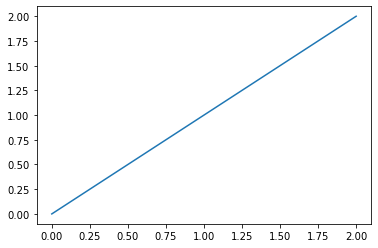

In [57]:
fig, ax = plt.subplots()
plt.plot([0,1,2],[0,1,2])
plt.show()
plt.close()

saving: /eos/user/a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SepEngBins_SigEffvsSpikeRej.png
saving: /eos/user/a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU50//COMBINED/SepEngBins_SigEffvsSpikeRej.pdf
DONE


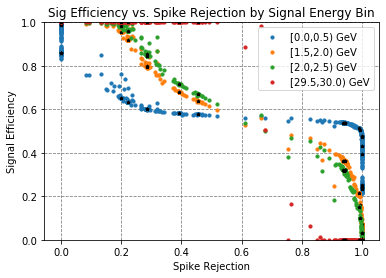

In [22]:
##-- Plot Energy bin ROC's together 
## can take final spike rej vals because they don't change per signal energy bin 

markerSize = 10
figx, figy = 8.5, 8.5
bbox_x = 1.01
legendOutside = 0
setFigSize = 0
ymin = 0.0
# eMinsToPlot = [0, 1, 5, 10, 15, 29]
# eMinsToPlot = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 10, 29]
# eMinsToPlot = [0, 2.5, 3, 29.5]
eMinsToPlot = [0, 1.5, 2, 29.5]

colors = ["C%s"%(i) for i in range(9)] 
shapes = ["o", "v", "^", "s", "+", "P", "X", "D"] # https://matplotlib.org/3.1.1/api/markers_api.html

colorShapePairs = []
for s in shapes:
    for c in colors:
        colShapePair = [c,s]
        colorShapePairs.append(colShapePair)

# black stars for final epochs
fig, ax = plt.subplots()

NplottedEs = 0

for NsigEbin in range(NsigEbins):
    emin, emax = sigEnergyBins[NsigEbin], sigEnergyBins[NsigEbin+1]
    if(emin not in eMinsToPlot): continue 
    
    colorShapePair = colorShapePairs[NplottedEs]
    NplottedEs += 1 
    color, shape = colorShapePair[0], colorShapePair[1] 
    plt.scatter(allSpikeRejVals,
                eval("allSigEffs_%s"%(NsigEbin)),
                c = color,
                marker = shape,
                s = markerSize,
                label = "[%s,%s) GeV"%(emin,emax)
               )
    plt.scatter(lastEpochSpikeRejVals,
                eval("lastEpochSigEffs_%s"%(NsigEbin)),
                c = 'black',
                marker = '*',
                s = markerSize,
#                 label = "[%s,%s)"%(emin,emax)
               )
    
plt.title("Sig Efficiency vs. Spike Rejection by Signal Energy Bin")
plt.xlabel("Spike Rejection")
plt.ylabel("Signal Efficiency")

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.set_ylim(ymin,1)
#     plt.legend(loc='upper right')
# plt.legend(loc='best')

if(legendOutside): plt.legend(fontsize='xx-small',bbox_to_anchor=(bbox_x, 1), loc='upper left', title = r"$\lambda_{Sig}$, $\lambda_{Spike}$")
else: plt.legend(loc='best')
if(setFigSize): fig.set_size_inches(figx, figy, forward=True)  

if(inline_plots):
    plt.show()
else:     
    print("saving:",'%s/COMBINED/SepEngBins_SigEffvsSpikeRej.png'%(ol))
    plt.savefig('%s/COMBINED/SepEngBins_SigEffvsSpikeRej.png'%(ol))
# plt.show()
# plt.close()    

# lastEpochSigEffVals
# lastEpochSpikeRejVals 

    
print("DONE")

In [113]:
##-- Recreate for each signal energy bin 

ie = nEpochs-1

# for ie in range(0,nEpochs):
plt.hist2d(LambdaSigVals_npa,
           LambdaSpikeVals_npa,
           bins=[x_bins,y_bins],
           weights=eval('SigEffVals_%s_npa * SpikeRejVals_%s_npa'%(ie,ie)),
           vmin=0,
           vmax=1,
#            cmin=0.0000000001
           )

plt.title("Signal eff. * Spike Rej.")
plt.xlabel("$\lambda_{Signal}$")
plt.ylabel("$\lambda_{Spike}$")
plt.colorbar()
if(inline_plots):
    plt.show()
else:
    print("saving:",'%s/COMBINED/SigEff_times_SpikeRej.png'%(ol))
    plt.savefig('%s/COMBINED/SigEff_times_SpikeRej.png'%(ol))
plt.close()
    
print("DONE")


saving: /eos/user/a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU0//COMBINED/SigEff_times_SpikeRej.png
saving: /eos/user/a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU0//COMBINED/SigEff_times_SpikeRej.pdf
DONE


In [115]:
allSpikeRejVals = []
allSigEffVals = []
finalEpochSigEffs = []
finalEpochSpikeRejs = []

# ie = nEpochs-1
for i in range(0,len(Histories)):
    for ie in range(0,nEpochs):
        allSigEffVals.append(Histories[i]['sig_eff_val'][ie])
        allSpikeRejVals.append(Histories[i]['spike_rej_val'][ie])
        
        if(ie == nEpochs-1): 
            finalEpochSigEffs.append(Histories[i]['sig_eff_val'][ie])
            finalEpochSpikeRejs.append(Histories[i]['spike_rej_val'][ie])
        
allSigEffVals_npa = np.array(allSigEffVals)
allSpikeRejVals_npa = np.array(allSpikeRejVals)
finalEpochSigEffs_npa = np.array(finalEpochSigEffs)
finalEpochSpikeRejs_npa = np.array(finalEpochSpikeRejs)

fig, ax = plt.subplots()

plt.scatter(allSpikeRejVals_npa,
            allSigEffVals_npa,
            c = 'C0',
            marker = 'o',
            label = "All Epochs"
           )

plt.scatter(finalEpochSpikeRejs_npa,
            finalEpochSigEffs_npa,
            c = 'C1',
            marker = '*',
            label = "Final Epochs"
           )

plt.title("Sig Efficiency vs. Spike Rejection")
plt.xlabel("Spike Rejection")
plt.ylabel("Signal Efficiency")

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.legend(loc='upper right')
if(inline_plots):
    plt.show()
else:
    print("saving:",'%s/COMBINED/SigEffvsSpikeRej.png'%(ol))
    plt.savefig('%s/COMBINED/SigEffvsSpikeRej.png'%(ol))
plt.close()

print("DONE")

saving: /eos/user/a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU0//COMBINED/SigEffvsSpikeRej.png
saving: /eos/user/a/atishelm/www/EcalL1Optimization/DoubleWeightsOptimization/PU0//COMBINED/SigEffvsSpikeRej.pdf
DONE


In [ ]:




# Extra code below 








In [ ]:
fig, ax = plt.subplots()

plt.scatter(SpikeRejVals_npa,
            SigEffVals_npa
           )

plt.title("Sig Efficiency vs. Spike Rejection")
plt.xlabel("Spike Rejection")
plt.ylabel("Signal Efficiency")

plt.ylim(0.9,1)

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

In [13]:
##-- systematically scan parameters here 

##-- lambda signal, lambda spike, batch size, 
## perform many experiments and save all of the results 
## dont need too many epochs

## Write code to run a lot of experiments, try different lambda,
## lambdas not normalized, maybe try to keep at sum = 1. (0.7, 0.3), etc...
## efficiency in bins of energy and time of spike 

##-- Want to look at:
# signal: eff for each (Energy)
# spike: rejection for each (Energy, time shift) 

# and try scanning learning rate 

# e2 = Experiment(50, 256, 5e-3, lambda_sig=1.5, lambda_spike=1, lambda_norm=0.1, min_delta=0.5, initial_weights=[0.,0.2,0.5,-0.1])

nepochs_ = 1

e2 = Experiment(nepochs_, 256, 5e-3, lambda_sig=1.5, lambda_spike=1, lambda_norm=0.1, min_delta=0.5, initial_weights=[0.,0.2,0.5,-0.1])
e2.set_lr_scheduler(get_lr_scheduler_exp(0.8, 6, True))

In [ ]:
numWaveforms = 1000
nAxRows, nAxCols = 2, 2
width, height = 10, 10

# f,ax = plt.subplots(nAxRows,nAxCols, figsize=(width,height))
# ax[0][0].plot(digis1[:numWaveforms,:].T)
# ax[0][0].set_title("Signal Digis")
# ax[0][1].plot(digis2[:numWaveforms,:].T)
# ax[0][1].set_title("Spike Digis")
# ax[1][0].set_title("Transverse Energies")
# ax[1][0].hist(signalEnergy, bins=100, range=(0,50), alpha=0.5, label="Signal Energy")
# ax[1][0].hist(spikeEnergy, bins=100, range=(0,50), alpha=0.5, label="Spike Energy")
# ax[1][0].legend(loc='upper right')
# ax[1][1].set_title("Spike Times (ns)")
# ax[1][1].hist(spikeTime, bins=100, range=(122,150), alpha=0.5, label="Spike Time")
# ax[1][1].legend(loc='upper right')
# plt.savefig('%s/Digis.png'%(ol))
# plt.close()
# plt.show()

In [266]:
e2.train(train_data, val_data)
print("DONE")

sig energy: tensor([ 0.4611,  0.3470, 24.0256,  ...,  7.1474,  1.5515, 16.3715])
spike energy: tensor([ 6.8815,  5.4135,  9.1001,  ...,  4.4694,  4.7199, 13.4328])
spike time: tensor([124.2208, 125.7561, 124.2024,  ..., 124.4122, 124.2632, 127.3830])
0) loss: 6.65162, loss sig: 0.25751, loss spike: 6.06897, |grad|: 10.19, Sig.eff.98.06, Spike rej.0.00
weights_2: [ 0.5903276  -0.37196344 -0.1903707   0.18564974 -0.21364324]
Updating lr: epoch 0, from 0.00500000 to 0.00500000
1) loss: 3.94581, loss sig: 0.37888, loss spike: 2.98336, |grad|: 22.90, Sig.eff.5.86, Spike rej.100.00
weights_2: [-0.7455973  -0.32809845  0.11032358  0.80289537  0.1604768 ]
Updating lr: epoch 1, from 0.00500000 to 0.00481746
2) loss: 3.79562, loss sig: 0.36402, loss spike: 3.19076, |grad|: 5.99, Sig.eff.89.67, Spike rej.22.87
weights_2: [-0.72702396 -0.26778945  0.07599808  0.85261464  0.06620075]
Updating lr: epoch 2, from 0.00481746 to 0.00447214
3) loss: 1.59729, loss sig: 0.43367, loss spike: 0.90522, |grad|

In [93]:
e2.save('model4_5w.json')

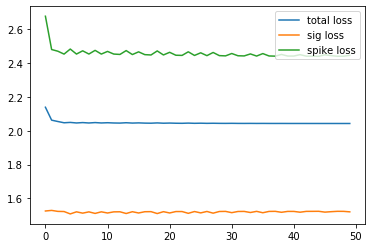

In [121]:
plt.plot(e2.history['loss'], label='total loss')
plt.plot(e2.history['loss_sig'], label='sig loss')
plt.plot(e2.history['loss_spike'], label='spike loss')
plt.legend()

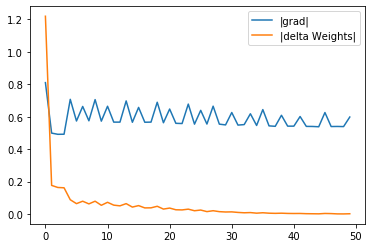

In [122]:
plt.plot(e2.history['grad_mod'], label='|grad|')
plt.plot(e2.history['delta_weights_mod'], label='|delta Weights|')
plt.legend()

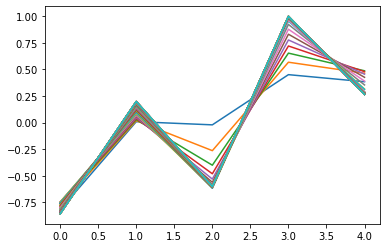

In [64]:
plt.plot(np.array(e.history['weights_2']).T)

[[ 0.5903276  -0.37196344 -0.1903707   0.18564974 -0.21364324]
 [-0.7455973  -0.32809845  0.11032358  0.80289537  0.1604768 ]
 [-0.72702396 -0.26778945  0.07599808  0.85261464  0.06620075]
 [-0.78783214 -0.22982     0.1065785   0.7877865   0.12328714]
 [-0.8622577  -0.18655615  0.16134942  0.78214276  0.10532173]
 [-0.86104023 -0.14440681  0.0617089   0.98673576 -0.04299762]
 [-0.895618   -0.10824619  0.06282895  0.9868269  -0.04579164]
 [-0.9068354  -0.08083235  0.0637247   0.9629201  -0.03897711]
 [-0.9451744  -0.06119614  0.08149878  0.9236975   0.0011743 ]
 [-0.937474   -0.0587549   0.07138549  0.9468843  -0.02204086]]


Text(0.5, 0, 'epochs')

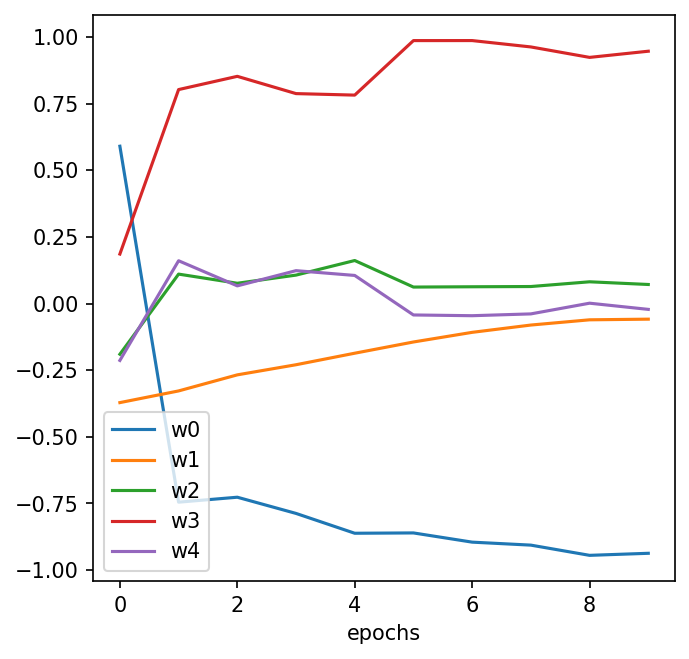

In [362]:
w2 = np.array(e2.history['weights_2'])
print(w2)
for i in range(5):
    plt.plot(w2[:,i], label=f"w{i}")
plt.legend()
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

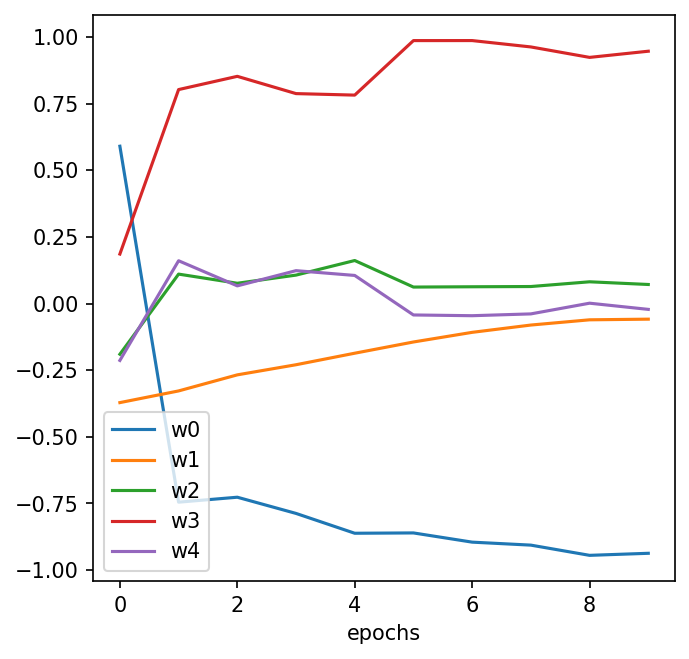

In [361]:
w2 = np.array(e2.history['weights_2'])
for i in range(5):
    plt.plot(w2[:,i], label=f"w{i}")
plt.legend()
plt.xlabel('epochs')

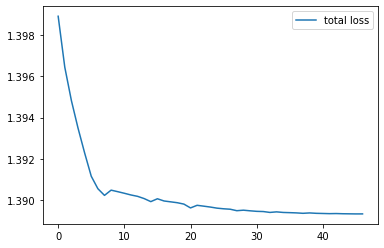

In [125]:
plt.plot(e.history['loss'][3:], label='total loss')
#plt.plot(e.history['loss_sig'][3:], label='sig loss')
#plt.plot(e.history['loss_spike'][3:], label='spike loss')
plt.legend()

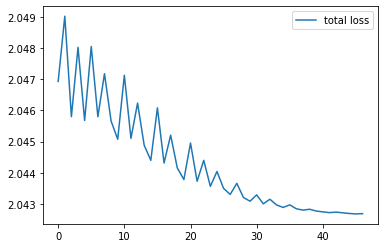

In [126]:
plt.plot(e2.history['loss'][3:], label='total loss')
#plt.plot(e.history['loss_sig'][3:], label='sig loss')
#plt.plot(e.history['loss_spike'][3:], label='spike loss')
plt.legend()

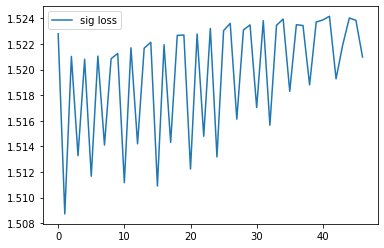

In [127]:
plt.plot(e2.history['loss_sig'][3:], label='sig loss')
#plt.plot(e.history['loss_spike'][3:], label='spike loss')
plt.legend()

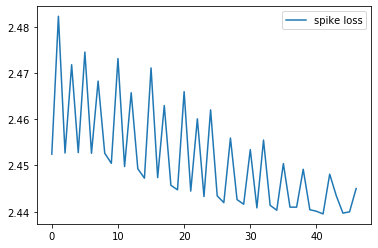

In [128]:
plt.plot(e2.history['loss_spike'][3:], label='spike loss')
#plt.plot(e.history['loss_spike'][3:], label='spike loss')
plt.legend()

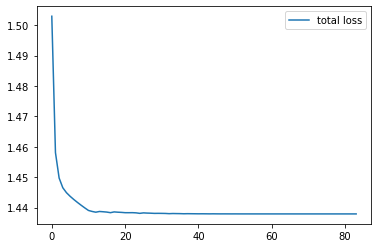

In [100]:
plt.plot(e2.history['loss'], label='total loss')
#plt.plot(e2.history['loss_sig'], label='sig loss')
#plt.plot(e2.history['loss_spike'], label='spike loss')
plt.legend()

In [14]:
optimization.save('optimization.json')

In [19]:
os.system('cat optimization.json')

0

"{'epochs': 10, 'lr': 0.0009378748862299283, 'batch_size': 256, 'lambda_sig': 1.5, 'lambda_spike': 1, 'lambda_norm': 0.1, 'min_delta': 0.5, 'weights_1': tensor([-0.5469, -0.5469,  0.2656,  0.4844,  0.3438]), 'weights_2_four': tensor([-0.0772,  0.0584,  0.9813, -0.0447], requires_grad=True), 'history': defaultdict(<class 'list'>, {'loss': [5.928076642775522, 3.0825640805308168, 3.383296189854174, 2.5274477998302163, 1.2588271669222244, 1.213037164772258, 1.1985421965355059, 1.1856681251784587, 1.1742182516289192, 1.1661930605386204], 'loss_sig': [0.28427422426636734, 0.4119411562763576, 0.376521922946072, 0.39751248230502384, 0.431944337141073, 0.4232706858668538, 0.4141929393569311, 0.40877127868023894, 0.40367601152566895, 0.4016172409563967], 'loss_spike': [5.373686370153144, 2.1589766407990747, 2.7776475437070594, 1.8902509532643346, 0.5689976473728771, 0.5367858056457706, 0.5364103399595828, 0.5316492361231983, 0.5277924072497372, 0.5224799210432255], 'grad_mod': [8.619264, 19.2332